# Introduction

This python library has been developed in close collaboration with Dr. Florian Hollerweger. The goals and outcomes of 
which has been influenced by Dr. Hollerweger's on going electroacoustic composition *Stimmen* (German: 
'voices'), a collaboration with Berlin-based vocal and performance artist Christine Scherzer 
that received a Faculty Development Grant in fall 2018.

- *The electroacoustic composition Stimmen (German: ‘voices’) is a celebration of the human voice, of orality as a medium of communication that precisely by stretching the securities of asserted meaning reveals truth to those who keep listening in the absence of words.*

This library is meant to be a framework for easily applying DSP algorithms that will analyze, edit, and reconstruct an audio signal both temporaly and stereoscopically

### Dependencies

- soundfile  | pip install soundfile  |
- matplotlib | pip install matplotlib |
- numpy      | pip install numpy      |
- scipy      | pip install scipy      |

# Getting Started 

After ensuring that you have the neccessary depencies installed to your current working environment you can
import the `SignalLibrary` module

Once you have copied the audio file that you wish to import into your working directory you can proceed to 
create a WavFile object.


In [1]:
%matplotlib inline 

In [2]:
import SignalLibrary as sl
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

audioFile = "Peak3.wav"
sig = sl.WavFile(audioFile)

## Get Signal Envelope 

Before you can extract the various audio events from the imported audio file you will need to first analyze
the signals envelope. The WavFile class has a couple of methods to help us achieve this. These two methods are 
`get_env_pd()` and `get_env_rms()`. I recommend mostly using `get_env_pd()` for it returns a very smooth envelope
without attenuating the signal, with varying amounts of resolution.


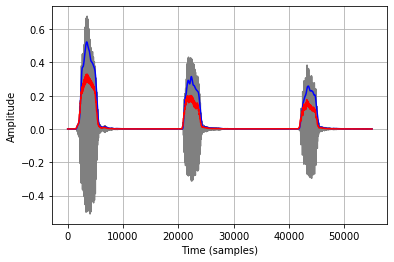

In [3]:
b = 35
lpf = 100
fOrder = 4

envPD = sig.get_env_pd(sig.data, b, lpf, fOrder, sig.sampleRate)

windowSize = 200

envRMS = sig.get_env_rms(sig.data, windowSize)

plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.plot(sig.data, 'grey')
plt.plot(envPD, 'blue')
plt.plot(envRMS, 'red')
plt.grid()
plt.show()

## Populate the `audio_events` List

*NOTE: This step can be skipped in the case that you are using the `calc_shift()` function.*

The next step will be to populate the audio events list, accessible via the WavFile object. After the audio has been analyzed, the indivdual audio events will be represented as objects of the `AudioEvent()` class.
Using a generated envelope (see previous section) we can excute the following code. 

In [4]:
atk = 0.01
rel = 0.009

sig.get_audio_events(sig.data, envPD, atk, rel)

I recommend fine tuning the atkThresh and relThresh to achieve the best results. 
If you are unsure of what to set these values to I recommend using a graph, like the one displayed above, to assess the threshold of a given audio signal. 
My method for deciding atkThresh and relThresh is to plot the original `sig.data` overlayed with the `get_env_pd()` envelope and assess what attak and release values I would need to capture the smallest audio event in my signal. 

## Calculating the Audio Shift (AUDIO GRAVITY)

### Mathematically Explanation

A main feature of this library is rearranging audio events temporaly along a timeline. 
To determine the behavior of the audio events movement along a timeline, we decided to use the equation of 
gravity as a model. The equation i'm referring to being... 

## $g = \frac{G \left( m1 \cdot m2 \right) }{r^2}$

Obviously audio events don't have mass or distance that we can calculate, so we needed to take some artistic
liberties with this equation. For our purposes mass = the root means square (RMS) of the given signal. The distance 
r is time, in seconds, derived from the number of samples in between each audio events envelope peak index. 
We use this equation to return an integer of + or - samples shifted. The equation returns one value of samples for two "mass bodies". 

To determine how many samples each audio event gets shifted, we determine the ratio of the two events RMS values. 
This means that a large RMS value signal, when calculated against a smaller RMS value signal, will have an uneven
ratio. The result is that the larger mass will only be shifted a little, while the smaller mass will be shifted
a lot. Two bodies of relatively similar RMS values will be shifted equivalently to one another.

We implement this equation in the form of matricies. 

## $ g = G(\frac{M}{R^2}s \cdot mR)$

In this case $M$ represents a matrix of RMS (mass) values which is then divided by the squared value of $R$, a matrix of time distances (in seconds). $S$ represents the audio sampling rate which multiplies the quotient into a number of samples. At this point we have a matrix of values that is symmetrical above the leading diagnol. This is not what we want. We then multiply this matrix by $mR$ which is a matrix of ratio values, in which any two audio events will have a ratio that will sum to 1, derived from their RMS (mass). Below is an example of what this ratio matrix might look like. 

\begin{equation}
  \begin{bmatrix}
    0 & 0.75 & 0.4 \\
    0.25 & 0 & 0.5 \\
    0.6 & 0.5 & 0
  \end{bmatrix}
  \label{eq:aeqn}
\end{equation}

In [5]:
rM = np.array([[0, 0.75, 0.4],
            [0.25, 0, 0.5],
            [0.6, 0.5, 0]])
print(rM)

[[0.   0.75 0.4 ]
 [0.25 0.   0.5 ]
 [0.6  0.5  0.  ]]


In this equation $G$ is an integer. It is used to scale the shifted values, thus making the shifting more or less dramatic. There is still one more step that needs to be addressed. We squared all of our time distances thus making all values in the matrix positive. Negative values move the audio event left in the time domain, and vice versa, positive values move it right. The solution to this is to simply make all values above the leading diagnol negative. The last step is to sum each column into a 1D array with each element indicating a total number of samples shifted for each audio event. 

### Code Examples

Though the WavFile class does contain two methods called `gravEq()` and `gravEq_M()` (M in this case standing for 
matrix) the method for calculating the shift amount for each AudioEvent is called `calc_shift()`. Conveniently 
`calc_shift()` will populate the `audio_events` list for you if you haven't already done so. Meaning you are not 
required to run `get_audio_events()` first. If you do so, it won't hurt anything, it will simply skip over that step.
Because of this though we still will need to pass in an envelope. 

In [6]:
atk = 0.01
rel = 0.009

G = 1

sig.calc_shift(sig.data, envPD, atk, rel, G)

## Viewing Audio Events

In some instances, it might be usefull to view individual audio events. The first method is to simply print the params of the individual audio events.

In [7]:
sig.audio_events[0].print_event_params()

---------------------
Start    = 1675
Peak     = 3449
End      = 6224
RMS      = 0.2101
Offset   = 3394
Pan      = 100
---------------------


You also can graph the audio event. This will display the original data, the signals envelope, and the envelope peak. The enevelope peak is what is used to compare the distanced between the various audio events. 

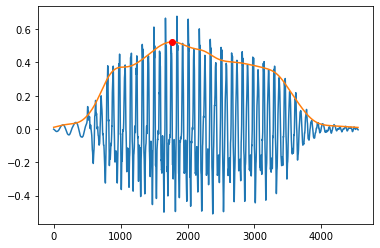

In [8]:
sig.audio_events[0].show_event()

## Reconstruction

### Mono 

After above steps have been completed you can begin to reconstruct your signal. The process is similar for both
Mono and Stereo. The first step is creating a new array that your audio will be added to. After that you can pass in your newly created array and your audio event list into the into the `reconstruct_mono()` method. 

In [9]:
array_length = len(sig.data)

r_mono = sl.Reconstruct().new_mono(array_length)
r_mono = sl.Reconstruct().reconstruct_mono(r_mono, sig.audio_events)

### Stereo

Reconstructing a stereo signal is nearly identical. 

In [10]:
r_stereo = sl.Reconstruct().new_stereo(array_length) 
r_stereo = sl.Reconstruct().reconstruct_stereo(r_stereo, sig.audio_events)

## Visualizion: Time Shift

In this example you will be able to see how the audio events move in time after they have been reconstructed. Note that adjusting the `G` parameter will affect how much or how little the events will be shifted in time. 

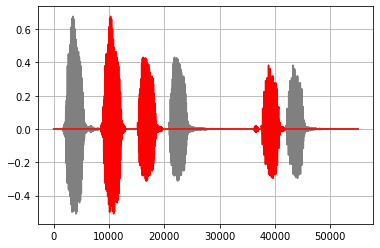

In [11]:
atk = 0.01
rel = 0.009

G = 2

sig.calc_shift(sig.data, envPD, atk, rel, G)

r_mono = sl.Reconstruct().new_mono(len(sig.data))
r_mono = sl.Reconstruct().reconstruct_mono(r_mono, sig.audio_events)

plt.plot(sig.data, 'grey') # original data
plt.plot(r_mono, 'red') # reconstructed signal
plt.grid()
plt.show()

## Visualization: Attack and Release Thresh

In some instances it might be helpful to visualize the detected audio event in comparison with the original signal. This can be helpful and identifying if your attack and/or release thresholds are either too high or too low. The graph will show the detected signale. 

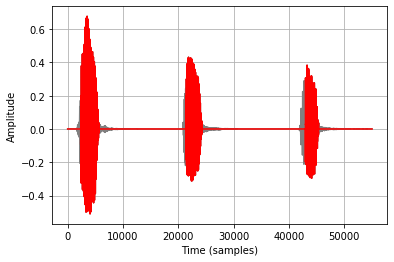

In [12]:
atk = 0.2
rel = 0.03

sig.get_audio_events(sig.data, envPD, atk, rel)

r_mono = sl.Reconstruct().new_mono(len(sig.data))
r_mono = sl.Reconstruct().reconstruct_mono(r_mono, sig.audio_events)

plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.plot(sig.data, 'grey') # original data
plt.plot(r_mono, 'red') # reconstructed signal
plt.grid()
plt.show()

Note: In this example I have purposefully set attack and release thresholds that imperfectely capture the signal. Observe how the beginnings and endings of some of these events are grey. Grey indicates audio information that will not be present in the reconstructed signal. This may cause unattural or choppy sounding audio clips in the final product. As a rule of thumb, attack should be higher than release, and the threshold should be adjusted to capture what would be considered the smallest audio event in your original audio signal that you wish to capture. 

## Write Audio

After that we can use `r_stereo` or `r_mono` as our newly constructed audio signal. 

In [13]:
sig.write2wav('jupyter_example_file.wav', r_mono)

In [15]:
# r = np.reshape(r_stereo, (2, len(sig.data))

# ipd.Audio([r[0],r[1]], rate=sig.sampleRate)
ipd.Audio('jupyter_example_file.wav')